<a href="https://colab.research.google.com/github/Naveen-1-1/hybrid-finetuning-ecommerce-llm-agent-bot/blob/main/NLP_Project_Phases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 0: Environment Setup & Verification

## 0.1: GPU Runtime Setup

In [1]:
# Check GPU availability
!nvidia-smi

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"\n{'='*50}")
    print("GPU DETAILS")
    print('='*50)
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
else:
    print("\n⚠️ WARNING: GPU not available! Check runtime settings.")

Wed Nov 19 01:28:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 0.2: Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directory in Drive
import os
project_path = '/content/drive/MyDrive/NLP_Project'
os.makedirs(project_path, exist_ok=True)
os.makedirs(f'{project_path}/data', exist_ok=True)
os.makedirs(f'{project_path}/models', exist_ok=True)
os.makedirs(f'{project_path}/results', exist_ok=True)
os.makedirs(f'{project_path}/checkpoints', exist_ok=True)

print(f"✓ Project directory created at: {project_path}")
print(f"\nDirectory structure:")
!ls -la /content/drive/MyDrive/NLP_Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Project directory created at: /content/drive/MyDrive/NLP_Project

Directory structure:
total 16
drwx------ 2 root root 4096 Nov 19 01:28 checkpoints
drwx------ 2 root root 4096 Nov 19 01:28 data
drwx------ 2 root root 4096 Nov 19 01:28 models
drwx------ 2 root root 4096 Nov 19 01:28 results


## 0.3: Install Required Libraries

In [3]:
print("Installing required packages...")
!pip install -q peft accelerate bitsandbytes
!pip install -q sentence-transformers faiss-cpu
!pip install -q rouge-score bert-score
!pip install -q datasets

print("\n" + "="*50)
print("VERIFYING INSTALLATIONS")
print("="*50)

# Verify installations
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import peft
import sentence_transformers
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

print("✓ All core libraries imported successfully!")
print(f"\nLibrary versions:")
print(f"  PyTorch: {torch.__version__}")
print(f"  Transformers: {transformers.__version__}")
print(f"  PEFT: {peft.__version__}")
print(f"  Sentence Transformers: {sentence_transformers.__version__}")

Installing required packages...

VERIFYING INSTALLATIONS
✓ All core libraries imported successfully!

Library versions:
  PyTorch: 2.8.0+cu126
  Transformers: 4.57.1
  PEFT: 0.17.1
  Sentence Transformers: 5.1.2


## 0.4: Download & Inspect Bitext Dataset

In [4]:
from datasets import load_dataset
import pandas as pd

print("Downloading Bitext dataset from Hugging Face...")

# Load the dataset
dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

print("\n" + "="*60)
print("DATASET STRUCTURE")
print("="*60)
print(dataset)

# Convert to pandas for easier analysis
df = pd.DataFrame(dataset['train'])

print("\n" + "="*60)
print("BASIC STATISTICS")
print("="*60)
print(f"Total examples: {len(df)}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

print("\n" + "="*60)
print("FIRST 3 EXAMPLES")
print("="*60)
for idx, row in df.head(3).iterrows():
    print(f"\nExample {idx + 1}:")
    print(f"Category: {row.get('category', 'N/A')}")
    print(f"Intent: {row.get('intent', 'N/A')}")
    print(f"Query: {row.get('instruction', row.get('query', 'N/A'))}")
    print(f"Response: {row.get('response', row.get('completion', 'N/A'))[:200]}...")
    print("-" * 60)

# Category distribution
print("\n" + "="*60)
print("CATEGORY DISTRIBUTION")
print("="*60)
if 'category' in df.columns:
    print(df['category'].value_counts())
if 'intent' in df.columns:
    print(f"\nUnique intents: {df['intent'].nunique()}")
    print("\nTop 10 intents:")
    print(df['intent'].value_counts().head(10))

# Text length analysis
print("\n" + "="*60)
print("TEXT LENGTH STATISTICS")
print("="*60)
query_col = 'instruction' if 'instruction' in df.columns else 'query'
response_col = 'response' if 'response' in df.columns else 'completion'

df['query_length'] = df[query_col].astype(str).str.len()
df['response_length'] = df[response_col].astype(str).str.len()

print(f"\nQuery lengths:\n{df['query_length'].describe()}")
print(f"\nResponse lengths:\n{df['response_length'].describe()}")

# Save to Drive for persistence
save_path = '/content/drive/MyDrive/NLP_Project/data/bitext_full.csv'
df.to_csv(save_path, index=False)
print(f"\n✓ Dataset saved to: {save_path}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



DATASET STRUCTURE
DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})

BASIC STATISTICS
Total examples: 26872

Column names: ['flags', 'instruction', 'category', 'intent', 'response']

Data types:
flags          object
instruction    object
category       object
intent         object
response       object
dtype: object

Missing values:
flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64

FIRST 3 EXAMPLES

Example 1:
Category: ORDER
Intent: cancel_order
Query: question about cancelling order {{Order Number}}
Response: I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to...
------------------------------------------------------------

Example 2:
Category: ORDER
Intent: cancel_order
Query: i have a quest

## 0.5 GPU Model Load Test

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

print("Testing model loading with quantization...")
print("=" * 60)

# Clear any existing models from memory
gc.collect()
torch.cuda.empty_cache()

model_name = "microsoft/phi-2"

try:
    print(f"\n1. Loading tokenizer for {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        trust_remote_code=True
    )
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print("   ✓ Tokenizer loaded")

    print(f"\n2. Loading model in 4-bit quantization...")
    print(f"   GPU memory before loading: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        load_in_4bit=True,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=torch.float16
    )

    print(f"   ✓ Model loaded successfully!")
    print(f"   GPU memory after loading: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"   Model device: {model.device}")

    print(f"\n3. Testing inference...")
    prompt = "Customer: How do I track my order? Assistant:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\n   Generated response:\n   {response}")

    print("\n" + "="*60)
    print("✓ GPU STRESS TEST PASSED!")
    print("="*60)
    print(f"Peak GPU memory: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")

    # Cleanup
    del model
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()

except Exception as e:
    print(f"\n✗ GPU STRESS TEST FAILED!")
    print(f"Error: {str(e)}")
    import traceback
    traceback.print_exc()

Testing model loading with quantization...

1. Loading tokenizer for microsoft/phi-2...


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


   ✓ Tokenizer loaded

2. Loading model in 4-bit quantization...
   GPU memory before loading: 0.00 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

   ✓ Model loaded successfully!
   GPU memory after loading: 1.94 GB
   Model device: cuda:0

3. Testing inference...

   Generated response:
   Customer: How do I track my order? Assistant: Once your order is shipped, you will receive an email with tracking information. You can track your order by going to the shipping portal and clicking on the tracking link.


✓ GPU STRESS TEST PASSED!
Peak GPU memory: 2.65 GB


## 0.6: Manual Category Inspection

In [6]:
import pandas as pd
import random

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/bitext_full.csv')

# Sample 5 examples from each category for manual inspection
print("="*80)
print("MANUAL CATEGORY INSPECTION FOR DETERMINISTIC/INDETERMINISTIC CLASSIFICATION")
print("="*80)

categories = df['category'].unique()

for cat in sorted(categories):
    print(f"\n{'='*80}")
    print(f"CATEGORY: {cat}")
    print(f"Total examples: {len(df[df['category'] == cat])}")
    print('='*80)

    # Sample 5 random examples
    samples = df[df['category'] == cat].sample(n=min(5, len(df[df['category'] == cat])), random_state=42)

    for idx, row in samples.iterrows():
        print(f"\nIntent: {row['intent']}")
        print(f"Query: {row['instruction']}")
        print(f"Response: {row['response'][:300]}...")
        print("-" * 80)

MANUAL CATEGORY INSPECTION FOR DETERMINISTIC/INDETERMINISTIC CLASSIFICATION

CATEGORY: ACCOUNT
Total examples: 5986

Intent: registration_problems
Query: where to notify of problems with sign-up?
Response: Glad you contacted to us regarding the problems you encountered during the sign-up process. We value your feedback and want to ensure a smooth experience for all our users. To notify us of any sign-up issues or problems, we recommend contacting our customer support team. They are available {{Custome...
--------------------------------------------------------------------------------

Intent: switch_account
Query: wanna  use the {{Account Type}} profile help me
Response: I'll get right on it! I'm thrilled to assist you in leveraging the perks of our {{Account Type}} profile. Let's make this transition smooth and enjoyable:

1. **Logging In**: Start by signing in to your account.
2. **Navigate to Profile Settings**: Once you're logged in, head to your account's "{{Pr...
----------------

## 0.7: Creating Binary Dataset

In [7]:
import pandas as pd

# Load full dataset
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/bitext_full.csv')

print("="*60)
print("CREATING BINARY CLASSIFICATION DATASET (KEEPING PLACEHOLDERS)")
print("="*60)

# Define deterministic and indeterministic categories based on our analysis
deterministic_categories = ['CONTACT', 'INVOICE', 'SHIPPING', 'SUBSCRIPTION', 'CANCEL']
indeterministic_categories = ['ACCOUNT', 'ORDER', 'FEEDBACK']

# Filter dataset
df_deterministic = df[df['category'].isin(deterministic_categories)].copy()
df_indeterministic = df[df['category'].isin(indeterministic_categories)].copy()

# Add binary label
df_deterministic['label'] = 0  # 0 = deterministic (retrieval)
df_indeterministic['label'] = 1  # 1 = indeterministic (LLM generation)

# Combine
df_binary = pd.concat([df_deterministic, df_indeterministic], ignore_index=True)

# Shuffle
df_binary = df_binary.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n📊 DATASET STATISTICS:")
print(f"Total examples: {len(df_binary):,}")
print(f"Deterministic (label=0): {len(df_deterministic):,} ({len(df_deterministic)/len(df_binary)*100:.1f}%)")
print(f"Indeterministic (label=1): {len(df_indeterministic):,} ({len(df_indeterministic)/len(df_binary)*100:.1f}%)")

print("\n📊 Category distribution:")
print(df_binary['category'].value_counts())

print("\n📊 Intent distribution (top 10):")
print(df_binary['intent'].value_counts().head(10))

print("\n📊 Placeholder usage:")
# Count examples with placeholders
df_binary['has_placeholder'] = df_binary['response'].str.contains('{{', regex=False)
print(f"Examples with placeholders: {df_binary['has_placeholder'].sum():,} ({df_binary['has_placeholder'].sum()/len(df_binary)*100:.1f}%)")

print("\n📊 Language variation flags distribution (top 10):")
print(df_binary['flags'].value_counts().head(10))

# Save
output_path = '/content/drive/MyDrive/NLP_Project/data/bitext_binary_classification.csv'
df_binary.to_csv(output_path, index=False)
print(f"\n✅ Binary classification dataset saved to: {output_path}")

# Show samples
print("\n" + "="*60)
print("SAMPLE DETERMINISTIC EXAMPLES")
print("="*60)
for idx, row in df_binary[df_binary['label']==0].head(2).iterrows():
    print(f"\nCategory: {row['category']} | Intent: {row['intent']}")
    print(f"Query: {row['instruction']}")
    print(f"Response: {row['response'][:200]}...")
    print("-" * 60)

print("\n" + "="*60)
print("SAMPLE INDETERMINISTIC EXAMPLES")
print("="*60)
for idx, row in df_binary[df_binary['label']==1].head(2).iterrows():
    print(f"\nCategory: {row['category']} | Intent: {row['intent']}")
    print(f"Query: {row['instruction']}")
    print(f"Response: {row['response'][:200]}...")
    print("-" * 60)

CREATING BINARY CLASSIFICATION DATASET (KEEPING PLACEHOLDERS)

📊 DATASET STATISTICS:
Total examples: 19,888
Deterministic (label=0): 7,917 (39.8%)
Indeterministic (label=1): 11,971 (60.2%)

📊 Category distribution:
category
ACCOUNT         5986
ORDER           3988
CONTACT         1999
INVOICE         1999
FEEDBACK        1997
SHIPPING        1970
SUBSCRIPTION     999
CANCEL           950
Name: count, dtype: int64

📊 Intent distribution (top 10):
intent
contact_customer_service    1000
switch_account              1000
complaint                   1000
check_invoice               1000
edit_account                1000
get_invoice                  999
contact_human_agent          999
registration_problems        999
newsletter_subscription      999
cancel_order                 998
Name: count, dtype: int64

📊 Placeholder usage:
Examples with placeholders: 9,963 (50.1%)

📊 Language variation flags distribution (top 10):
flags
BL      3876
BLQ     1784
BIL     1600
BLM      877
BILQ     825


# Phase 1

## 1.1: Feature Engineering & Train/Val/Test Split

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/bitext_binary_classification.csv')

print("="*60)
print("PHASE 1: BINARY CLASSIFIER TRAINING")
print("="*60)

# Feature engineering
print("\n1. Extracting features...")

# Basic features
df['query_length'] = df['instruction'].str.len()
df['word_count'] = df['instruction'].str.split().str.len()
df['has_question_mark'] = df['instruction'].str.contains('\?').astype(int)
df['has_order_number'] = df['instruction'].str.contains('order|purchase', case=False).astype(int)
df['has_account'] = df['instruction'].str.contains('account|profile', case=False).astype(int)

print("✓ Basic features extracted")
print(f"  - query_length, word_count, has_question_mark, has_order_number, has_account")

# Split data
print("\n2. Splitting data (70-15-15)...")
X = df['instruction'].values
y = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"✓ Data split complete:")
print(f"  - Training: {len(X_train):,} examples")
print(f"  - Validation: {len(X_val):,} examples")
print(f"  - Test: {len(X_test):,} examples")

# Check label distribution
print("\n3. Label distribution:")
for split_name, split_y in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    det = (split_y == 0).sum()
    indet = (split_y == 1).sum()
    print(f"  {split_name:6s}: Deterministic={det:,} ({det/len(split_y)*100:.1f}%), Indeterministic={indet:,} ({indet/len(split_y)*100:.1f}%)")

# TF-IDF Vectorization
print("\n4. Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"✓ TF-IDF vectorization complete")
print(f"  - Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"  - Feature matrix shape: {X_train_tfidf.shape}")

<>:23: SyntaxWarning: invalid escape sequence '\?'
<>:23: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-3615539990.py:23: SyntaxWarning: invalid escape sequence '\?'
  df['has_question_mark'] = df['instruction'].str.contains('\?').astype(int)


PHASE 1: BINARY CLASSIFIER TRAINING

1. Extracting features...
✓ Basic features extracted
  - query_length, word_count, has_question_mark, has_order_number, has_account

2. Splitting data (70-15-15)...
✓ Data split complete:
  - Training: 13,921 examples
  - Validation: 2,983 examples
  - Test: 2,984 examples

3. Label distribution:
  Train : Deterministic=5,542 (39.8%), Indeterministic=8,379 (60.2%)
  Val   : Deterministic=1,187 (39.8%), Indeterministic=1,796 (60.2%)
  Test  : Deterministic=1,188 (39.8%), Indeterministic=1,796 (60.2%)

4. Creating TF-IDF features...
✓ TF-IDF vectorization complete
  - Vocabulary size: 1,000
  - Feature matrix shape: (13921, 1000)


## 1.2: Train Logistic Regression Classifier


TRAINING CLASSIFIER

5. Training Logistic Regression...
✓ Training complete

6. Validation Set Performance:
Accuracy: 99.83%

Classification Report:
                 precision    recall  f1-score   support

  Deterministic       1.00      1.00      1.00      1187
Indeterministic       1.00      1.00      1.00      1796

       accuracy                           1.00      2983
      macro avg       1.00      1.00      1.00      2983
   weighted avg       1.00      1.00      1.00      2983


7. Confusion Matrix (Validation):
[[1185    2]
 [   3 1793]]
✓ Confusion matrix saved


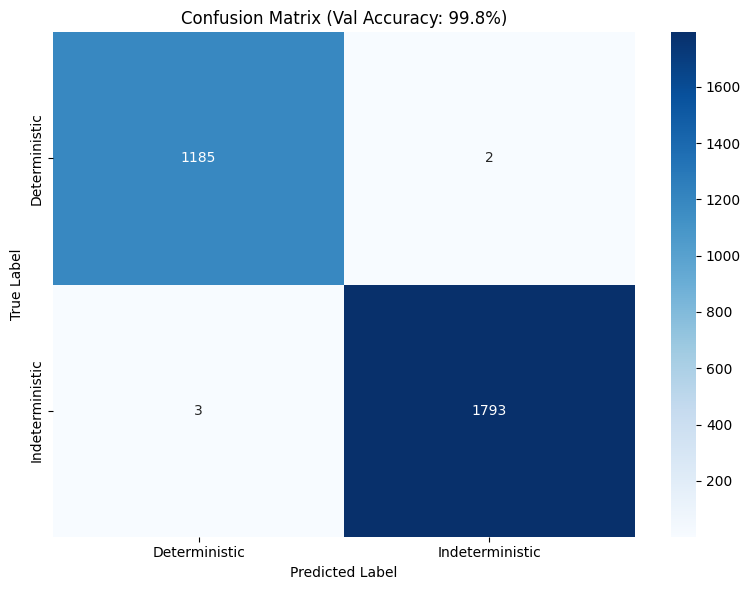


8. Test Set Performance:
Accuracy: 99.90%

Classification Report:
                 precision    recall  f1-score   support

  Deterministic       1.00      1.00      1.00      1188
Indeterministic       1.00      1.00      1.00      1796

       accuracy                           1.00      2984
      macro avg       1.00      1.00      1.00      2984
   weighted avg       1.00      1.00      1.00      2984


✓ Models saved to /content/drive/MyDrive/NLP_Project/models/classifier/

PHASE 1 RESULTS
Validation Accuracy: 99.83%
Test Accuracy: 99.90%

✅ PHASE 1 PASSED - Classifier is viable!
   Proceed to Phase 2A: Retrieval System


In [9]:
print("\n" + "="*60)
print("TRAINING CLASSIFIER")
print("="*60)

# Train logistic regression
print("\n5. Training Logistic Regression...")
clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)
print("✓ Training complete")

# Evaluate on validation set
print("\n6. Validation Set Performance:")
y_val_pred = clf.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {val_accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Deterministic', 'Indeterministic']))

# Confusion matrix
print("\n7. Confusion Matrix (Validation):")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Deterministic', 'Indeterministic'],
            yticklabels=['Deterministic', 'Indeterministic'])
plt.title(f'Confusion Matrix (Val Accuracy: {val_accuracy*100:.1f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/NLP_Project/results/classifier_confusion_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Confusion matrix saved")
plt.show()

# Test set performance
print("\n8. Test Set Performance:")
y_test_pred = clf.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Deterministic', 'Indeterministic']))

# Save model
import pickle
model_path = '/content/drive/MyDrive/NLP_Project/models/classifier/'
import os
os.makedirs(model_path, exist_ok=True)

with open(f'{model_path}/logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf, f)
with open(f'{model_path}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print(f"\n✓ Models saved to {model_path}")

# Critical decision
print("\n" + "="*60)
print("PHASE 1 RESULTS")
print("="*60)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

if test_accuracy >= 0.75:
    print("\n✅ PHASE 1 PASSED - Classifier is viable!")
    print("   Proceed to Phase 2A: Retrieval System")
elif test_accuracy >= 0.70:
    print("\n⚠️  PHASE 1 MARGINAL - Classifier works but not great")
    print("   Can proceed but may need improvements")
else:
    print("\n❌ PHASE 1 FAILED - Binary classification not working")
    print("   Need to pivot strategy or improve features")

# Phase 2

## 2A: Retrieval System Test

### 2A.1: Build Retrieval Index

In [10]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time

print("="*60)
print("PHASE 2A: RETRIEVAL SYSTEM")
print("="*60)

# Load data
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/bitext_binary_classification.csv')

# Get deterministic examples only
df_det = df[df['label'] == 0].reset_index(drop=True)
print(f"\n1. Loaded {len(df_det):,} deterministic examples")

# Hold out 200 for testing
from sklearn.model_selection import train_test_split
df_det_train, df_det_test = train_test_split(df_det, test_size=200, random_state=42)

print(f"   - Training index: {len(df_det_train):,} Q&A pairs")
print(f"   - Testing: {len(df_det_test):,} queries")

# Load sentence transformer model
print("\n2. Loading sentence-transformers model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("   ✓ Model loaded (384-dim embeddings)")

# Encode queries and responses for retrieval index
print("\n3. Encoding queries for retrieval index...")
start = time.time()
query_embeddings = model.encode(
    df_det_train['instruction'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)
elapsed = time.time() - start
print(f"   ✓ Encoded {len(df_det_train):,} queries in {elapsed:.1f}s ({len(df_det_train)/elapsed:.0f} queries/sec)")

# Build FAISS index
print("\n4. Building FAISS index...")
dimension = query_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance (can convert to cosine later)
index.add(query_embeddings.astype('float32'))
print(f"   ✓ FAISS index built with {index.ntotal:,} vectors")

# Save index and data
import pickle
retrieval_path = '/content/drive/MyDrive/NLP_Project/models/retrieval/'
import os
os.makedirs(retrieval_path, exist_ok=True)

faiss.write_index(index, f'{retrieval_path}/faiss_index.bin')
df_det_train.to_csv(f'{retrieval_path}/deterministic_qa_pairs.csv', index=False)
print(f"\n   ✓ Index saved to {retrieval_path}")

PHASE 2A: RETRIEVAL SYSTEM

1. Loaded 7,917 deterministic examples
   - Training index: 7,717 Q&A pairs
   - Testing: 200 queries

2. Loading sentence-transformers model...
   ✓ Model loaded (384-dim embeddings)

3. Encoding queries for retrieval index...


Batches:   0%|          | 0/242 [00:00<?, ?it/s]

   ✓ Encoded 7,717 queries in 4.0s (1946 queries/sec)

4. Building FAISS index...
   ✓ FAISS index built with 7,717 vectors

   ✓ Index saved to /content/drive/MyDrive/NLP_Project/models/retrieval/


### 2A.2: Test Retrieval Accuracy

In [11]:
print("\n" + "="*60)
print("TESTING RETRIEVAL ACCURACY")
print("="*60)

# Encode test queries
print("\n5. Encoding test queries...")
test_queries = df_det_test['instruction'].tolist()
test_embeddings = model.encode(test_queries, show_progress_bar=True, convert_to_numpy=True)

# Search for top-k matches
print("\n6. Searching for top-3 matches per query...")
k = 3
distances, indices = index.search(test_embeddings.astype('float32'), k)

# Evaluate retrieval accuracy
print("\n7. Evaluating retrieval accuracy...")

# For each test query, check if ANY of top-k matches have the same intent/category
def calculate_retrieval_metrics(df_test, df_train, indices, k_values=[1, 3]):
    results = {}

    for k in k_values:
        # Intent match (strict)
        intent_matches = 0
        # Category match (broader)
        category_matches = 0

        for i, test_row in df_test.iterrows():
            test_intent = test_row['intent']
            test_category = test_row['category']

            # Get top-k retrieved intents and categories
            retrieved_indices = indices[i][:k]
            retrieved_intents = df_train.iloc[retrieved_indices]['intent'].values
            retrieved_categories = df_train.iloc[retrieved_indices]['category'].values

            # Check if test intent/category in retrieved results
            if test_intent in retrieved_intents:
                intent_matches += 1
            if test_category in retrieved_categories:
                category_matches += 1

        intent_accuracy = intent_matches / len(df_test) * 100
        category_accuracy = category_matches / len(df_test) * 100

        results[f'Top-{k}'] = {
            'intent_accuracy': intent_accuracy,
            'category_accuracy': category_accuracy
        }

        print(f"\n   Top-{k} Retrieval:")
        print(f"      Intent Match: {intent_matches}/{len(df_test)} ({intent_accuracy:.1f}%)")
        print(f"      Category Match: {category_matches}/{len(df_test)} ({category_accuracy:.1f}%)")

    return results

results = calculate_retrieval_metrics(df_det_test.reset_index(drop=True), df_det_train, indices)

# Show some example retrievals
print("\n8. Sample Retrieval Examples:")
print("="*60)

for i in range(3):
    test_query = df_det_test.iloc[i]['instruction']
    test_intent = df_det_test.iloc[i]['intent']
    test_category = df_det_test.iloc[i]['category']

    print(f"\nTest Query {i+1}:")
    print(f"  Query: {test_query}")
    print(f"  True Intent: {test_intent} | Category: {test_category}")
    print(f"\n  Top-3 Retrieved:")

    for rank, idx in enumerate(indices[i][:3], 1):
        retrieved_query = df_det_train.iloc[idx]['instruction']
        retrieved_intent = df_det_train.iloc[idx]['intent']
        retrieved_category = df_det_train.iloc[idx]['category']
        retrieved_response = df_det_train.iloc[idx]['response'][:100]
        distance = distances[i][rank-1]

        match = "✓" if retrieved_intent == test_intent else "✗"
        print(f"    {rank}. [{match}] (dist={distance:.3f})")
        print(f"       Intent: {retrieved_intent} | Category: {retrieved_category}")
        print(f"       Query: {retrieved_query}")
        print(f"       Response: {retrieved_response}...")
        print()

# Critical decision
print("\n" + "="*60)
print("PHASE 2A RESULTS")
print("="*60)
print(f"Top-1 Intent Accuracy: {results['Top-1']['intent_accuracy']:.1f}%")
print(f"Top-3 Intent Accuracy: {results['Top-3']['intent_accuracy']:.1f}%")

if results['Top-3']['intent_accuracy'] >= 70:
    print("\n✅ PHASE 2A PASSED - Retrieval system is viable!")
    print("   Proceed to Phase 2B: LLM Fine-tuning")
elif results['Top-3']['intent_accuracy'] >= 60:
    print("\n⚠️  PHASE 2A MARGINAL - Retrieval works but not great")
    print("   Can proceed but may need threshold tuning")
else:
    print("\n❌ PHASE 2A FAILED - Retrieval accuracy too low")
    print("   May need different embedding model or retrieval strategy")


TESTING RETRIEVAL ACCURACY

5. Encoding test queries...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


6. Searching for top-3 matches per query...

7. Evaluating retrieval accuracy...

   Top-1 Retrieval:
      Intent Match: 197/200 (98.5%)
      Category Match: 200/200 (100.0%)

   Top-3 Retrieval:
      Intent Match: 200/200 (100.0%)
      Category Match: 200/200 (100.0%)

8. Sample Retrieval Examples:

Test Query 1:
  Query: help me to see at what time i can reach customer service
  True Intent: contact_customer_service | Category: CONTACT

  Top-3 Retrieved:
    1. [✓] (dist=0.027)
       Intent: contact_customer_service | Category: CONTACT
       Query: I need help to see at what time I can reach customer service
       Response: We value your outreach! I'm in tune with the fact that you need assistance in determining the availa...

    2. [✓] (dist=0.051)
       Intent: contact_customer_service | Category: CONTACT
       Query: I want help to see at what time I can reach customer service
       Response: Thank you for reaching out! I understand your eagerness to know the specific